# Solving a Single Pipeline Model using Plasmo
## Jordan Jalving & Victor Zavala

## Import Plasmo and Ipopt

In [13]:
push!(LOAD_PATH,"/home/juser/JuliaBox/PlasmoShortCourse/src")
using Plasmo
using Ipopt
using PyPlot

## Define a global horizon variable, and import some gas component models

In [2]:
global horizon = 3600*24
include("gas_components.jl");

## Set our parameters are usual

In [14]:
#pipeline data
pipe_length = 60000
diameter = 0.92
time_grid = 1:24
x_grid = 1:10
min_pressure = 1
max_pressure = 100
min_flow = 1
max_flow = 300

#compressor data
dp_min = 1
dp_max = 20
min_power = 1
max_power = 10000
comp_cost = 0.1;

## Set pipeline, compressor, and junction data

In [24]:
pdata = PipeData(pipe_length,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow) #pipe data
cdata = CompData(dp_min,dp_max,min_power,max_power,comp_cost) #compressor data
supply_node_data = NodeData(time_grid,1,300,0,54,54,-1000,0.0)
demand_node_data = NodeData(time_grid,0,0,1,50,70,-1000,0.0);

## Create the graph representing a pipeline and two junctions (supply and demand)

In [25]:
#Create the Plasmo Graph Model
model = GraphModel()
graph = getgraph(model)
n1 = add_node!(model)
n2 = add_node!(model)
pipe = add_edge!(model,n1,n2);

## Setup our model for our PDE system

In [26]:
#call a function which produced the pipeline model
euler_model = euleractivelink(pdata,cdata)
#provide a steady state initial condition
#roll this into the model
euler_model = steadystatestart(euler_model,pdata)

supply = gasnode(supply_node_data)
demand = gasnode(demand_node_data)

#set the models on our nodes and edge
setmodel!(n1,supply)
setmodel!(n2,demand)
setmodel!(pipe,euler_model)

## Add linking constraints between component models

In [27]:
#Node conservation in n1
@linkconstraint(model,graph,n1,[t = time_grid], 0 == sum(in_edges(graph,n1)[i][:fout][t] for i = 1:length(in_edges(graph,n1))) -
sum(out_edges(graph,n1)[i][:fin][t] for i = 1:length(out_edges(graph,n1))) + n1[:total_supplied][t] - n1[:total_delivered][t])

#Node conservation in n2
@linkconstraint(model,graph,n2,[t = time_grid], 0 == sum(in_edges(graph,n2)[i][:fout][t] for i = 1:length(in_edges(graph,n2))) -
sum(out_edges(graph,n2)[i][:fin][t] for i = 1:length(out_edges(graph,n2))) + n2[:total_supplied][t] - n2[:total_delivered][t])

#set linking constraints for our pipe boundary condition
@linkconstraint(model,graph,pipe,[t = time_grid],pipe[:pin][t] == getconnectedfrom(graph,pipe)[:pressure][t])
@linkconstraint(model,graph,pipe,[t = time_grid],pipe[:pout][t] == getconnectedto(graph,pipe)[:pressure][t]);

## Fix the demand at n2

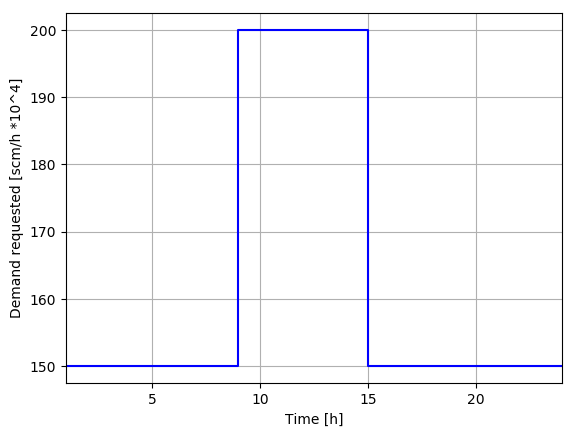

In [28]:
gas_demands = fill(150,length(time_grid))
gas_demands[10:15] = 200
step(time_grid,gas_demands,color="blue")
ax = gca()
ax[:set_xlim]([1,24])
xlabel("Time [h]")
ylabel("Demand requested [scm/h *10^4]")
grid("on")

In [29]:
d = getmodel(n2) #grab n2's model
@constraint(d,[t = time_grid],n2[:demand][1,t] == gas_demands[t]);

## Solve the pipe system

In [30]:
model.solver = IpoptSolver()
solve(model,graph)

Creating flattened graph model...
Finished model instantiation
This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11466
Number of nonzeros in inequality constraint Jacobian.:       98
Number of nonzeros in Lagrangian Hessian.............:     9798

Total number of variables............................:     3127
                     variables with only lower bounds:     1920
                variables with lower and upper bounds:     1152
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3031
Total number of inequality constraints...............:       49
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       48

iter    objective    inf

## Plot profiles

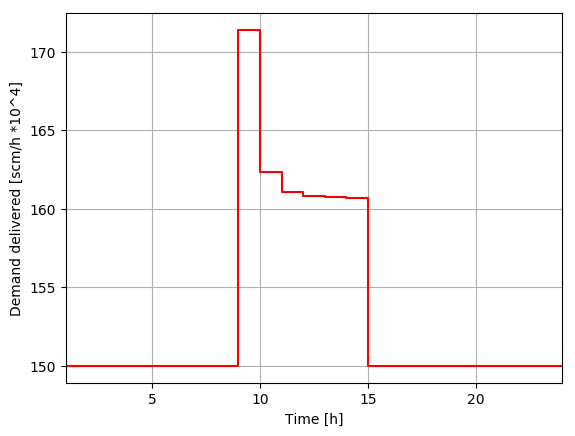

In [33]:
d_profile = getvalue(n2[:fdeliver])
step(time_grid,d_profile[:],color="red")
ax = gca()
ax[:set_xlim]([1,24])
xlabel("Time [h]")
ylabel("Demand delivered [scm/h *10^4]")
grid("on")

In [31]:
px = getvalue(pipe[:px])
fx = getvalue(pipe[:fx]);

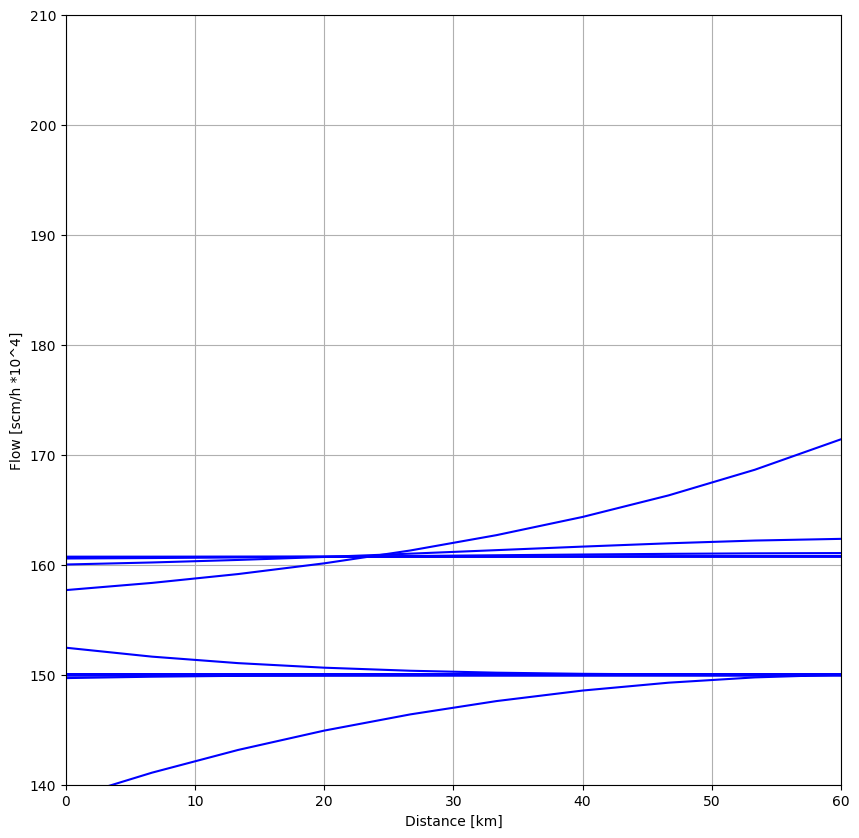

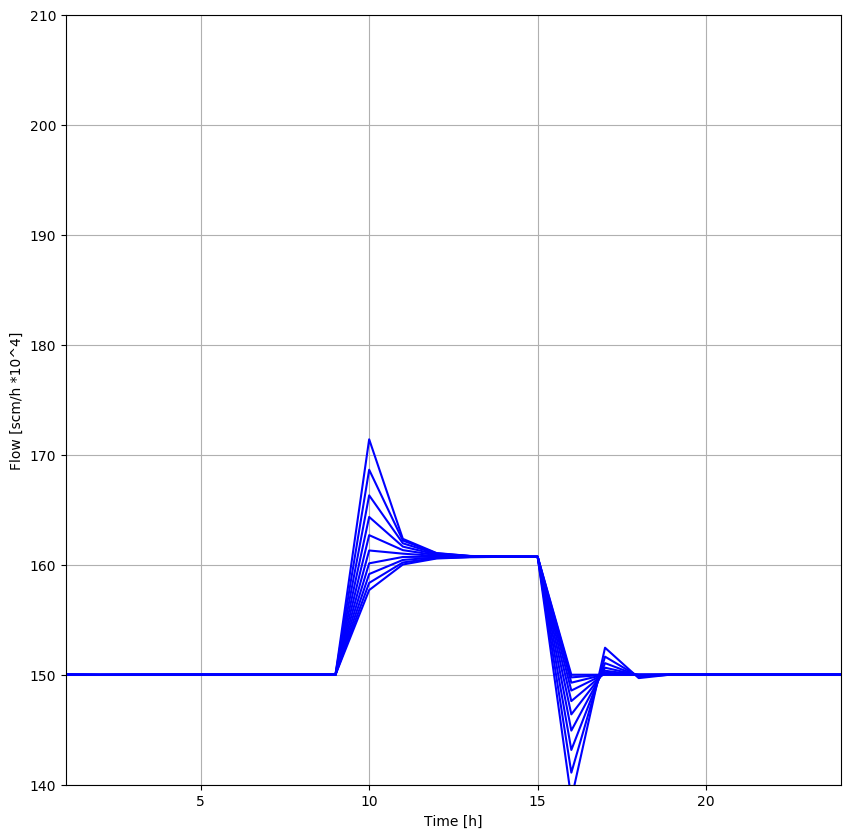

In [34]:
x_plot = linspace(0,pipe_length/1000,length(x_grid))
flow_profile = getvalue(pipe[:fx])
fig = figure("pipeline_axial_flows",figsize=(10,10))
for t = time_grid
    plot(x_plot,flow_profile[t,:],color="blue")
    ax = gca()
    ax[:set_ylim]([140,210])
    ax[:set_xlim]([0,60])
    xlabel("Distance [km]")
    ylabel("Flow [scm/h *10^4]")
end
grid("on")
fig = figure("pipeline_temporal_flows",figsize=(10,10))
for x = x_grid
    plot(time_grid,flow_profile[:,x],color="blue")
    ax = gca()
    ax[:set_ylim]([140,210])
    ax[:set_xlim]([1,24])
    xlabel("Time [h]")
    ylabel("Flow [scm/h *10^4]")
end
grid("on")

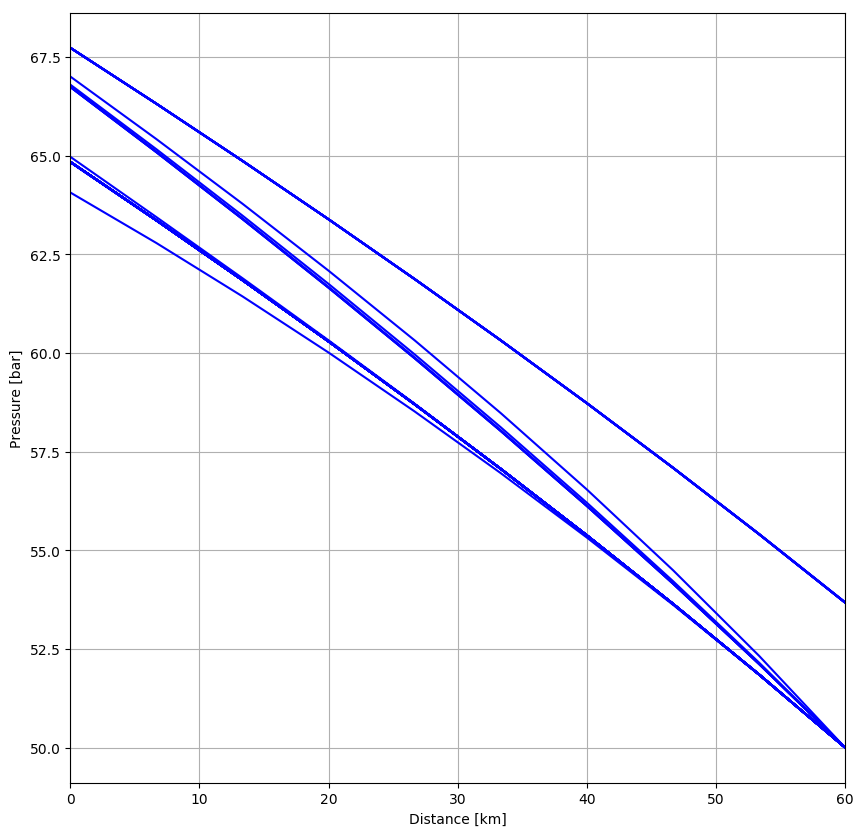

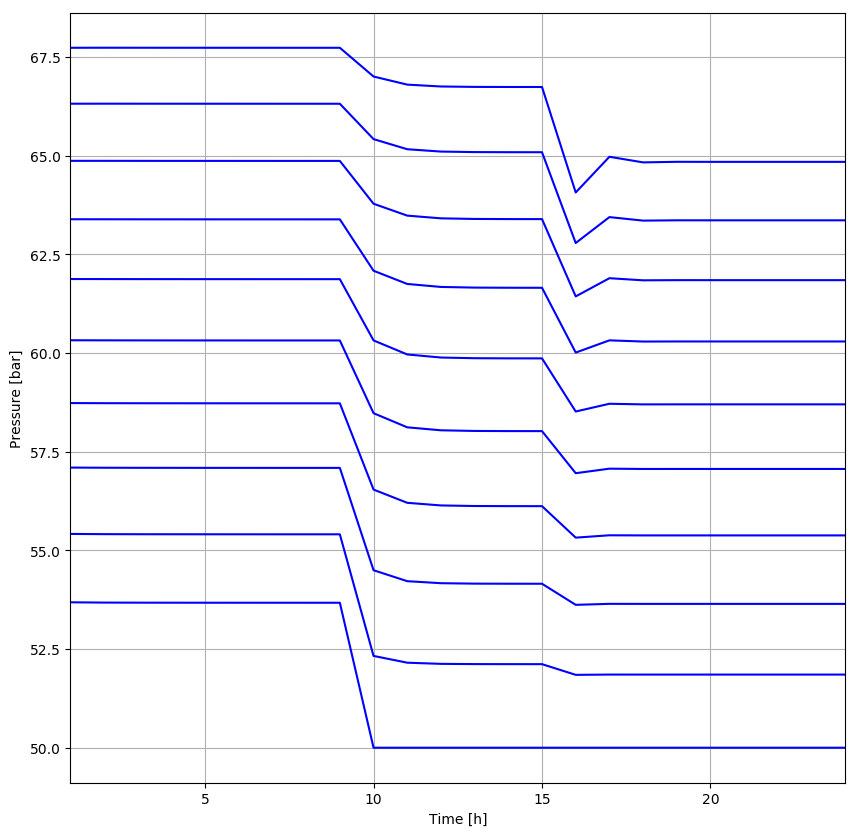

In [35]:
press_profile = getvalue(pipe[:px])
fig = figure("pipeline_spatial_flows",figsize=(10,10))
for t = time_grid
    plot(x_plot,press_profile[t,:],color = "blue")
    ax = gca()
    ax[:set_xlim]([0,60])
    xlabel("Distance [km]")
    ylabel("Pressure [bar]")
end
grid("on")
fig = figure("pipeline_temporal_flows",figsize=(10,10))
for x = x_grid
    plot(time_grid,press_profile[:,x],color = "blue")
    ax = gca()
    ax[:set_xlim]([1,24])
    xlabel("Time [h]")
    ylabel("Pressure [bar]")
end
grid("on")

# A closer look at gas_components.jl

# Gas Network Component Models
Here we will define the component models for our gas network.  While there is certainly some effort required to come up with valid model components, we will see that the system as a whole becomes easier to analyze and extend.

### Gas Node (Junction) Component
The gas node encompasses both supplies and demands.

In [ ]:
type NodeData
    time_grid
    n_supplies
    supply_upper
    n_demands
    pressure_lower
    pressure_upper
    demand_cost
    gen_cost
end

function gasnode(data::NodeData)
    m = Model()
    time_grid = data.time_grid
    supplies = collect(1:data.n_supplies)
    demands = collect(1:data.n_demands)
    @variable(m,data.pressure_lower <= pressure[time_grid] <= data.pressure_upper,start = 50)
    @variable(m,0 <= fgen[supplies,time_grid] <= data.supply_upper, start = 10)
    @variable(m,demand[demands,time_grid] >= 0)
    @variable(m,fdeliver[demands,time_grid] >= 0,start = 100)
    @constraint(m, flowLimit[d = demands,t = time_grid], fdeliver[d,t] <= demand[d,t])

    @variable(m,total_delivered[time_grid] >= 0)
    @variable(m,total_supplied[time_grid] >= 0)
    @constraint(m,sum_deliver[t = time_grid],total_delivered[t] == sum(fdeliver[d,t] for d in demands))
    @constraint(m,sum_supply[t = time_grid],total_supplied[t] == sum(fgen[s,t] for s in supplies))

    @variable(m,delivercost[demands]) #each demand has a deliver cost (revenue)
    @variable(m,total_delivercost)
    @variable(m,supplycost[supplies])
    @variable(m,total_supplycost)

    @constraint(m,[d = demands],delivercost[d] == sum(data.demand_cost*fdeliver[d,t] for t = time_grid))
    @constraint(m, integratedDemandCost, total_delivercost == sum(delivercost[d] for d = demands))
    @constraint(m,[s = supplies],supplycost[s] == sum(data.gen_cost*fgen[s,t] for t = time_grid))
    @constraint(m, integratedSupplyCost, total_supplycost == sum(supplycost[s] for s = supplies))

    @objective(m, Min, total_delivercost + total_supplycost)
    return m
end

### Gas Pipeline Components
Since pipeline components can be extremely diverse (various reduced models, active vs passive,etc...), it is helpful to define functions that manipulate a model.  We can then build up different pipeline models for different applications and set them to edges within our network.

In [ ]:
function euleractivelink(pdata,cdata)
    m = Model()
    m = basepipeequations(m,pdata)
    m = isothermaleulerequations(m,pdata)
    m = compressorequations(m,cdata)
    m = activepressureboundary(m,pipedata)
    m = ssinitialcondition(m,pipedata)
    m = linepackconstraint(m,pipedata)
    return m
end

In [ ]:
function eulerpassivelink(pdata)
    m = Model()
    m = basepipeequations(m,pdata)
    m = isothermaleulerequations(m,pdata)
    m = passivepressureboundary(m,pdata)
    m = ssinitialcondition(m,pdata)
    m = linepackconstraint(m,pdata)
    return m
end 

### Structs for pipe and compressor data

In [ ]:
#Pipe data struct
type PipeData
    len
    diameter
    time_grid
    x_grid
    min_pressure
    max_pressure
    min_flow
    max_flow
end

#Compressor data struct
type CompData
    dp_min
    dp_max
    min_power
    max_power
    cost
end

## Creating a gas pipeline component
## Functions can be used to modify and compose models

### Base Pipe Equations

In [ ]:
function basicpipeequations(m,pipedata)
    time_grid = pipedata.time_grid 
    x_grid = pipedata.x_grid
    min_pressure = pipedata.min_pressure
    max_pressure = pipedata.max_pressure
    min_flow = pipedata.min_flow
    max_flow = pipedata.max_flow
    @variable(m,pin[time_grid] >= 0, start = 60)
    @variable(m,pout[time_grid] >= 0, start = 60)
    @variable(m,fin[time_grid] >=0, start = 100)
    @variable(m,fout[time_grid] >= 0, start = 100)
    @variable(m, min_pressure <= px[time_grid,x_grid] <= max_pressure, start = 60)#start = 0.5*($data.min_pressure + $data.max_pressure)) #60   # link pressure profile - [bar]
    @variable(m, min_flow <= fx[time_grid,x_grid] <= max_flow, start = 10)#100 #start = 0.5*($data.min_flow + $data.max_flow))
    @constraint(m, flow_in[t = time_grid],  fx[t,1] == fin[t])
    @constraint(m, flow_out[t = time_grid], fx[t,x_grid[end]] == fout[t])
    return m
end;

### Isothermal Euler Equations

In [ ]:
function isothermaleulerequations(m,pipedata)
    #pipe parameters
    time_grid = pipedata.time_grid 
    x_grid = pipedata.x_grid
    diameter = pipedata.diameter
    len = pipedata.len
    x_grid = pipedata.x_grid
    time_grid = pipedata.time_grid
    area = (1/4)*pi*diameter*diameter
    lam = (2*log10(3.7*diameter/(eps*dfac)))^(-2)   #pipe friction coefficient
    c1 = (pfac2/ffac2)*(nu2/area)
    c2 = area*(ffac2/pfac2)
    c3 = area*(pfac2/ffac2)*(8*lam*nu2)/(pi*pi*diameter^5)
    dx = len / (length(x_grid) - 1)
    dt = horizon / length(time_grid)
    
    #variables and equations
    px = getvariable(m,px)
    fx = getvariable(m,fx)
    @variable(m, slack2[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable
    @variable(m, slack3[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable
    @variable(m, slack1[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable for friction loss term
    @NLconstraint(m, slackeq1[t = time_grid, x = x_grid],  slack1[t,x]*px[t,x] - c3*fx[t,x]*fx[t,x] == 0)
    @NLconstraint(m, slackeq2[t = time_grid, x = x_grid],  slack2[t,x]*px[t,x] - 2*c1*fx[t,x] == 0)
    @NLconstraint(m, slackeq3[t = time_grid, x = x_grid],  slack3[t,x]*px[t,x]*px[t,x] - c1*fx[t,x]*fx[t,x] == 0)
    @constraint(m, press[t = time_grid[1:end-1], x = x_grid[1:end-1]], (px[t+1,x]-px[t,x])/dt + c1*(fx[t+1,x+1]-fx[t+1,x])/dx == 0 )
    @constraint(m, flow[t = time_grid[1:end-1], x = x_grid[1:end-1]], (fx[t+1,x]-fx[t,x])/dt == -slack2[t+1,x]*(fx[t+1,x+1]-fx[t+1,x])/dx +
                                    slack3[t+1,x]*(px[t+1,x+1]-px[t+1,x])/dx -c2*(px[t+1,x+1]-px[t+1,x])/dx - slack1[t+1,x])
    return m
end;

### Compressor Equations

In [ ]:
function compressorequations(m,compressdata)
    time_grid = compressdata.time_grid
    dp_min = compressdata.dp_min
    dp_max = compressdata.dp_max
    min_power = compressdata.min_power 
    max_power = compressdata.max_power
    cost = compressdata.cost
    fin = getvariable(m,:fin)
    pin = getvariable(m,:pin)
    @variable(m, dp_min <= dp[time_grid] <= dp_max, start = 10)
    @variable(m, min_power <= pow[time_grid] <= max_power, start = 500)
    @variable(m, powercost)
    @NLconstraint(m, powereqn[t = time_grid], pow[t] == c4*fin[t]*(((pin[t]+dp[t])/pin[t])^om-1))
    @constraint(m,boostcosteqn, powercost == sum(cost*pow[t] for t = time_grid)*dt/3600)
    @objective(m, Min, powercost)
    return m
end;

### Boundary Conditions

In [ ]:
function activepressureboundary(m,pipedata)
    time_grid = pipe.time_grid
    px = getvariable(m,:px)
    pin = getvariable(m,:pin)
    dp = getvariable(m,:dp)
    pout = getvariable(m,:pout)
    @constraint(m,press_in[t = time_grid],  px[t,1] == pin[t] + dp[t])
    @constraint(m,press_out[t = time_grid], px[t,x_grid[end]] == pout[t])
    return m
end

In [ ]:
function passivepressureboundary(m,pipedata)
    time_grid = pipe.time_grid
    px = getvariable(m,:px)
    pin = getvariable(m,:pin)
    pout = getvariable(m,:pout)
    @constraint(m,press_in[t = time_grid],  px[t,1] == pin[t])
    @constraint(m,press_out[t = time_grid], px[t,x_grid[end]] == pout[t])
    return m
end

### Steady State Initial Condition

In [ ]:
function ssinitialconditions(m,pipedata)
    x_grid = pipedata.x_grid
    px = getvariable(m,:px)
    fx = getvariable(m,:fx)
    slack = getvariable(m,:slack)
    @constraint(m, mass_ss[t = 1, x = x_grid[1:end-1]], (fx[t,x+1] - fx[t,x]) == 0)
    @constraint(m, momentum_ss[t = 1, x = x_grid[1:end-1]], -c2*(px[t,x+1] - px[t,x])/dx - slack[t,x] == 0)
end

### Linepack Constraint

In [ ]:
function linepack(m,pipedata)
    time_grid = pipedata.time_grid
    @variable(m,linepack[time_grid])
    @constraint(m,linepack_def[t = time_grid],linepack[t] == sum(fx[t,x] for x in x_grid)*dx)
    #Periodic terminal constraint
    @constraint(m,linepack_cons, linepack[time_grid[end]] >= linepack[time_grid[1]])
end

## Even more modularity

![title](gas_coupling.png)

### Gas Junction Component (no supply or demand)

In [ ]:
################################
# Gas Node Component
################################
type JunctionData
    time_grid
    pressure_lower
    pressure_upper
end

function gasjunction(data)
    m = Model()
    time_grid = data.time_grid
    @variable(m,data.pressure_lower <= pressure[time_grid] <= data.pressure_upper, start = 60)
    @variable(m,supply[time_grid] >= 0)  #supply flow to gasnode
    @variable(m,deliver[time_grid] >= 0) #delivered flow from gas node
    return m
end;

### Gas Demand Component

In [ ]:
####################################
# Demand Component
####################################
type DemandData
    time_grid
    cost
end

function gasdemand(data)
    cost = data.cost
    time_grid = data.time_grid
    m = Model()
    @variable(m,fdeliver[time_grid] >= 0, start = 100)
    @variable(m, demandcost)
    @variable(m, fdemand[time_grid] >= 0)
    @constraint(m, flowLimit[t = time_grid], fdeliver[t] <= fdemand[t])
    @constraint(m, integratedGasCost, demandcost == sum(cost*fdeliver[t] for t = time_grid))
    @objective(m, Min, demandcost)
    return m
end;

### Gas Supply Component

In [ ]:
####################################
# Supply Component
####################################
type SupplyData
    time_grid
    cost
    fgen_lower
    fgen_upper
end

function gassupply(data)
    cost = data.cost
    time_grid = data.time_grid
    m = Model()
    @variable(m, data.fgen_lower <= fgen[time_grid] <= data.fgen_upper, start = 10)
    @variable(m,gencost[time_grid])
    @constraint(m,costconstraint[t = time_grid], gencost[t] == cost*fgen[t])
    return m
end;